In [2]:
# Importing Built Tools such as Notion , Slack
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END , START
# from langgraph.checkpoint import MemorySaver
from IPython.display import Image, display
from typing import Optional , Literal , TypedDict
from datetime import datetime
import re
import os
from dotenv import load_dotenv


from notion_api_tools import  append_toggle_with_bullets_for_change_log , update_block_content , delete_block , append_bulleted_list_to_block
from slack_tools import retrieve_channel_id_by_name , post_message_to_channel , fetch_replies_from_channel



class MyAgentState1(TypedDict):
    latest_meeting_topic : Optional[str]
    latest_email_meeting_summary : Optional[str]
    latest_action_items_data : Optional[str]
    structured_refined_email_summary : Optional[list]
    structured_list_of_action_items : Optional[list]
    notion_page_ids_list: Optional[list[dict]]
    slack_channel_id : Optional[str]
    slack_bot_id : Optional[str]
    pre_existing_notion_page_data: Optional[list[dict]]
    suggested_structured_changes: Optional[list]
    next_node: Optional[str]  # Add this to track the next node
    new_page_content_list : Optional[list]


In [3]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
# print(openai_api_key)

In [4]:

from notion_api_tools import add_page_to_action_items_database_table_by_id , get_each_notion_page_action_items_table_id_mapping


def process_changes(data_list):
        today_date = datetime.today().strftime('%Y-%m-%d')
        notion_page_to_action_items_table_id_matching = get_each_notion_page_action_items_table_id_mapping()
        for entry in data_list:
            page_id = entry.get("page_id")
            changes = entry.get("changes", [])
            change_logs = entry.get("changeLogs", [])
            suggested_action_items_list = entry.get("suggested_action_items_add" , [])
            
            for change in changes:
                block_id = change.get("objectId")
                change_type = change.get("ChangeType")
                content = change.get("ContentForChange")
                
                if change_type == "update":
                    update_block_content.invoke(input = { "updating_block_info"  :  {"blockId": block_id, "new_text_content": content}})
                elif change_type == "delete":
                    delete_block.invoke(input = {"deleting_block_info" : {"blockId": block_id}})
                elif change_type == "append":
                    append_bulleted_list_to_block.invoke(input = {"adding_content_info" : {"blockId": block_id, "bullet_points_list": [content]}})
            
            if change_logs:
                append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                    "NOTION_PAGE_ID": page_id,
                    "toggle_item_text": f"Change Log {today_date}",
                    "bullet_points_list": change_logs
                }})

            # action_item_data = {"action_item" : "This is to do by EOD" , "status" : "Not Started" , "assigned_to" : ["person-1" , "person-2"]}
            if suggested_action_items_list:
                for each_action_item_info in suggested_action_items_list:
                     temp_dict = {"action_item" : each_action_item_info.get("action_item_text") , "status" : each_action_item_info.get("status") , "assigned_to" : each_action_item_info.get("assignees")}
                     # now we should import a function here 
                     add_page_to_action_items_database_table_by_id(notion_page_to_action_items_table_id_matching.get(page_id) , temp_dict)
        
        # print("Tryong to add New Notion Page Id mapping to created Action Items Table , Should be defined")

In [5]:
from notion_api_tools import add_heading_to_page , add_bulleted_list_with_subpoints , append_new_topic_toggle_under_given_toggle_id , append_toggle_to_given_page , append_toggle_with_bullets_for_change_log , create_notion_table , add_new_notion_page_data_to_existing_notion_pages_database , get_each_notion_page_action_items_table_id_mapping , add_each_notion_page_action_items_table_id_mapping
from datetime import datetime


# notion_page_to_action_items_table_id_matching  = {
#     "18ae35223beb804fbfb3cce77e9a94fb" : "18be35223beb801e9930d555918b1a43",
#     "196e35223beb806a8889f2524d28bdaf" : "196e35223beb81228d00c817b034f906"
# }



# notion_page_to_action_items_table_id_matching = get_each_notion_page_action_items_table_id_mapping()
# print("Notion Pages mapping to Action Items table is \n")
# print(notion_page_to_action_items_table_id_matching)

def applying_new_topics_in_new_notion_page(notion_page_id ,latest_meeting_topic, latest_notes_list , extracted_action_items_list ):


    today_date = datetime.today().strftime('%Y-%m-%d')
    
    # step-1 :-  Applying Heading
    add_heading_to_page(notion_page_id , "This is related to Change Log")

    #step-2 :-  adding Toggle with Chaneg Log
    append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                "NOTION_PAGE_ID": notion_page_id,
                "toggle_item_text": f"Change Log {today_date}",
                "bullet_points_list": ["Added all new Topics"]
            }})

    # step-3 :- 
    latest_notes_toggle_block_id = append_toggle_to_given_page(notion_page_id , "Latest Notes")

    # Appending all topic blocks as children to latest_notes_toggle_block_id

    for each_topic_element in latest_notes_list:
        topic_name = each_topic_element.get("topic")
        sub_topics_list = each_topic_element.get("sub_topics")   # sub_topics_list is a list
        
        topic_toggle_block_id = append_new_topic_toggle_under_given_toggle_id(latest_notes_toggle_block_id , topic_name)

        # appending each-sub-topics with corresponding bullets
        # each_sub_topic has sub_topic name and bullet_points
        
        add_bulleted_list_with_subpoints(topic_toggle_block_id ,sub_topics_list)
    # added adding_action_items_table and inserting each action_item
    # step-4
    created_table_id = create_notion_table(notion_page_id)
    print("At creation of Action Items table")
    for each_action_item in extracted_action_items_list:
        each_action_item_info = {
            "action_item" : each_action_item.get("action_item_text"),
            "status" : each_action_item.get("status"),
            "assigned_to" : each_action_item.get("assignees")
        }
        # action_item_text = each_action_item.get("action_item_text")
        # status = each_action_item.get("status")
        # assignees_list = each_action_item.get("assignees")
        add_page_to_action_items_database_table_by_id(created_table_id , each_action_item_info)
    print("adding content new Notion Page completed , storing details of newly created Notion Page")
    # adding newly created Notion Page Info
    add_new_notion_page_data_to_existing_notion_pages_database(notion_page_id , latest_meeting_topic)
    print("Tryong to add New Notion Page Id mapping to created Action Items Table , Should be defined")
    add_each_notion_page_action_items_table_id_mapping(notion_page_id ,created_table_id)

In [6]:
from slack_tools import handle_sending_msg
from notion_api_tools import validate_notion_page

#checking whether notion page id is valid or not
async def get_valid_notion_page(state):
    while True:
        try:
            human_response = await handle_sending_msg(state["latest_meeting_topic"])
            print(f"📩 Received Notion Page ID: {human_response}")

            if human_response and await validate_notion_page(human_response):
                print("✅ Notion Page ID is valid!")
                return human_response
            else:
                print("❌ Notion Page ID is invalid. Asking admin again...")
                await handle_sending_msg("The Notion Page ID is invalid. Please provide a correct one.")

        except Exception as e:
            print(f"❌ Error while validating Notion Page: {e}")

In [7]:
from notion_api_tools import fetch_data_from_meetings_history_database_table , fetch_notion_page_content , append_bulleted_list_to_block , fetch_data_from_existing_notion_pages_data_database_table
import json
import re
import time
from notion_api_tools import update_block_content , delete_block , append_toggle_with_bullets_for_change_log  # ,  append_bulleted_list_to_block
from notion_api_tools import add_page_to_meetings_history_database_table
from datetime import datetime
from slack_tools import handle_sending_msg


llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai_api_key)

In [12]:
llm_response = llm.invoke("About Notion Pages")
print(llm_response)

2025-03-12 12:17:11,521 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
content="Notion is an all-in-one workspace that enables users to take notes, manage tasks, create databases, and collaborate with others. One of the key features of Notion is its ability to create and organize pages. Here’s an overview of Notion pages and their functionalities:\n\n### Basic Features of Notion Pages\n\n1. **Structure and Organization**:\n   - **Hierarchy**: Notion allows users to create nested pages, meaning you can have a main page with sub-pages, facilitating a structured approach to information.\n   - **Tags and Links**: You can tag pages, add links to other pages, or reference them, which helps in connecting related information.\n\n2. **Content Types**:\n   - **Text**: You can add plain text, formatted text, and even code blocks.\n   - **Media**: Pages support images, videos, audio files, and embed links from various services like Google Drive, Figma, etc

In [8]:
def getting_meeting_from_email(state :MyAgentState1)-> MyAgentState1 :

    print("Here we will get both Topic and Latest Email Summary as Input from Agent Invoking")
    print("Invoked getting_meeting_from_email")
    print("Getting latest Meeting to Invoke Agent")
    # state["latest_meeting_topic"] = "Hive Reviews and Demos"
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print(f"Latest Meeting topic got is {state["latest_meeting_topic"]}")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("LATEST MEETING SUMMARY IS \n")
    print(state["latest_email_meeting_summary"])
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("\nLATEST ACTION ITEMS DATA\n")
    print(state["latest_action_items_data"])
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")

    return state

In [9]:
def checking_new_or_old_topic(state : MyAgentState1) -> MyAgentState1 :
    print("Invoked  checking_new_or_old_topic")
    fetched_past_meetings_info = fetch_data_from_meetings_history_database_table("197e35223beb80039714f0cd468bce2e")
    latest_meeting_topic = state["latest_meeting_topic"]
    latest_meeting_info = {
        "meeting_name" : latest_meeting_topic,
        "happened_date" : "February 11, 2025"
    }

    # meetings_history_table_id = "197e35223beb80039714f0cd468bce2e"
    # Mechanism to add a new happened meeting to history table should be added
    # print("Adding current Meeting info to history")
    # add_page_to_meetings_history_database_table(latest_meeting_info)
    # print("Added Current Meeting into history")

    # existing_notion_pages_info = [  # replaced by defined function to get all existing notion pages info list
    #     {
    #         "page_id" : "id",
    #         "project_name" : "Marketing Agent"
    #     },
    #     {
    #         "page_id" : "id",
    #         "project_name" : "Documentation Agent"
    #     }
    # ]
    existing_notion_pages_info = fetch_data_from_existing_notion_pages_data_database_table()

    print("Existing Notion Pages info down , \n")
    print(existing_notion_pages_info)
    print("**********************************************************************************")
    print("**********************************************************************************")
    pages_id_list = [ each_page_info.get("notion_page_id") for each_page_info in existing_notion_pages_info]
    state["extracted_existing_notion_pages_id_list"] = pages_id_list

    prompt =f"""
    You are an AI assistant responsible for analyzing meeting records and determining whether the latest meeting topic is new or has already been covered in past meetings.

    ## **Input Data**:
    1. **Latest Meeting Information**:
    - Meeting Name: "{latest_meeting_info['meeting_name']}"
    - Happened Date: "{latest_meeting_info['happened_date']}"

    2. **Past Meeting Records**:
    The following meetings have already occurred:
    {json.dumps(fetched_past_meetings_info, indent=4)}

    3. **Existing Notion Project Records**:
    These project names currently exist in Notion:
    {json.dumps(existing_notion_pages_info, indent=4)}

    ## **Your Task**:
    1. Compare the **latest meeting name** with:
    - Past meeting records (`fetched_past_meetings_info`)
    - Existing Notion project records (`existing_notion_pages_info`)

    2. Determine whether the latest meeting is:
    - **A completely new topic** (i.e., not found in past meetings or existing projects).
    - **An already existing topic** (i.e., closely matching or identical to past meetings or existing projects).

    3. Respond with a JSON object in the following format:
    - If the topic **already exists**, respond with:
        ```json
        {{
            "status": "existing_topic",
            "matched_meeting_name": "<most relevant past meeting name or existing project>",
            "reason": "The topic closely matches a past meeting or an existing project.",
            "is_new_topic": "no"
        }}
        ```

    - If the topic **is new**, respond with:
        ```json
        {{
            "status": "new_topic",
            "new_topic_name": "<new meeting topic name>",
            "reason": "The topic has not been discussed before.",
            "is_new_topic": "yes"
        }}
        ```

    ## **Output Format (JSON)**:
    Strictly respond with the following JSON format without any additional text:
    ```json
    {{
        "status": "<new_topic/existing_topic>",
        "matched_meeting_name": "<if applicable, provide the most relevant past meeting name or existing topic>",
        "new_topic_name": "<if applicable, provide the new topic name>",
        "reason": "<explanation>",
        "is_new_topic": "<yes/no>"
    }}

    """
    print("Checking whether Topic is new or Existing by LLM")
    llm_response = llm.invoke(prompt)
    llm_content = llm_response.content
    print("Checking Completed")
    # print(llm_content)
    # changing llm_content to json and extracting is_new_topic 
    cleaned_json_str = re.sub(r'^```json\n|\n```$', '', llm_content.strip())
    try:
        json_data = json.loads(cleaned_json_str)
        print(json_data)
        is_new_topic = json_data.get("is_new_topic" , "")

    except Exception as e:
        print(e)

    state["topic_type"] = is_new_topic
    if is_new_topic == "yes":
        state["next_node"] = "process_new_meeting_topic"
    else :
        state["next_node"] = "getting_structured_meeting_summary"

    # state["next_node"] = "structured_refined_email_summary"
    print(f"Latest Topic Type is {is_new_topic}")
    return state

In [10]:
def decide_new_or_changes(state: MyAgentState1) -> str:
    if state.get("next_node") in ["process_new_meeting_topic", "getting_structured_meeting_summary"]:
        return state["next_node"]
    return END  # Prevent unintended loops

In [ ]:
# def getting_latest_meeting_summary(state : MyAgentState)-> MyAgentState:
#     print("Getting Latest Meeting Summary")
#     state["latest_email_meeting_summary"] = "This is the latest Meeting Summary Happened on a DATE"

# def sending_action_items_to_slack_channel(state : MyAgentState) -> MyAgentState:
#     state["latest_action_items_list"] = "This is a list of Latest Action Items got from Read.AI"
#     print("Sending Action Items which were got from Read.AI to a Slack Channel by using Slack API's")



def getting_structured_meeting_summary(state : MyAgentState1)-> MyAgentState1 :
    # state["structured_refined_email_summary"] = "This is a Structured Refined Email Summary in the form of a list of Dicts where Each Dict consist of Changes and ChangeLog"
    print("Getting a Structured Refined Summary from an LLM in the form of a List of Dicts")
    print("Getting existing Notion Pages Content")

    # pages_id_list = ["18ae35223beb804fbfb3cce77e9a94fb" , "196e35223beb806a8889f2524d28bdaf"]
    # existing_notion_pages_info is a variable used in previous node , which will be defined during running of code 
    # pages_id_list = [ each_page_info.get("notion_page_id") for each_page_info in existing_notion_pages_info]
    # pages_id_list = state["extracted_existing_notion_pages_id_list"]
    existing_notion_pages_info = fetch_data_from_existing_notion_pages_data_database_table()

    pages_id_list = [each_notion_page_info.get("notion_page_id") for each_notion_page_info in existing_notion_pages_info] 
    # notion_pages = [
    #     # {"page_id": "18ae35223beb804fbfb3cce77e9a94fb", "fetched_content": ""},
    #     # {"page_id": "196e35223beb806a8889f2524d28bdaf", "fetched_content": "Extracted content for Notion Page 2..."}
    # ]
    notion_pages_data = []
    # overall_notion_data  = ""


    for eachPageIdInfo in existing_notion_pages_info:
        each_dict = dict()
        each_dict["page_id"] = eachPageIdInfo.get("notion_page_id")
        each_dict["project_name"] = eachPageIdInfo.get("page_project_title")
        # notion_page_info = {"notion_page_id": eachPageId}
        # print(f"Debug Notion Page Info: {notion_page_info}")  # Debugging Step
        each_dict["fetched_content"] = str(fetch_notion_page_content.invoke(input = {"notion_page_id_info" : {"notion_page_id" :eachPageIdInfo.get("notion_page_id") }} ))
        notion_pages_data.append(each_dict)
        print("🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢")
        # print(each_dict["fetched_content"])
    print("Fetching Data from All Notion Pages Completed")
    state["pre_existing_notion_page_data"] = notion_pages_data   # list of strings

    for each_dict in state["pre_existing_notion_page_data"]:
        print("*********************")
        print(each_dict["page_id"])
        print(each_dict["project_name"])
        print(each_dict["fetched_content"])
        print("*************************")
    print("All Fetching completed , now it will be precessed by LLM to get list of changes to be made for each Notion Page")

    # Processing Notion Content and comparing with Latest Meeting summary
    latest_meeting_summary = state["latest_email_meeting_summary"]
    action_items = state["latest_action_items_data"]
    pre_existing_notion_page_data = state["pre_existing_notion_page_data"]

    print("Down Processing Stage")
    all_page_changes = []

    for page in pre_existing_notion_page_data:
        fetched_content = page["fetched_content"]
        print(fetched_content)
        page_id = page["page_id"]
        fetched_project_name = page["project_name"]

        # action_items = """"
        # Action Items:
        # * Pritesh Singh will complete the navigation feature by end of day today.
        # * Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.
        # * Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.
        # * Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.
        # * Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.
        # * Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.
        # * Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.
        # * Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.
        # """

        prompt = f"""
        You are an Intelligent Agent.

        You are working with content from a Notion Page. Your goal is to analyze the **Latest Meeting Summary** and compare it with the **Extracted Content** (which is from each Notion Page) to identify required changes that should be made in the Extracted Content.

        Additionally, you must analyze the **Action Items** and compare them with the **Extracted Content**. If any action item is relevant to a section in the extracted content, it should be added to a list called **"suggested_action_items_add"**.
        NOTE :- analyzed **Action Items** which you will be added into **"suggested_action_items_add"**  should be strictly specific to **Project Name**. if any action item matched with **Project Name** then only it should added into **"suggested_action_items_add"**

        **Each Notion Page belongs to a specific project, identified by its** `"project_name"`.  
        - The **Action Items** must be assigned **only if they are related to the same project** as the Notion Page. **(Important)**
        - Ignore unrelated action items that belong to other projects.**(Important)** 
        ---

        ### **Structure of Each Notion Page Content**
        Each Notion Page consists of the following **Main Sections**:

        1. **ChangeLog** → A record of past modifications to the page.
        - The **ChangeLog section** can be identified by entries in the following format:
            "Change Log - Date: 02/05/2025: {{id: 18be3522-3beb-80bb-9ed9-db0db98e9c3b}}"
        - Each entry contains a **date** and a **unique identifier (UUID)** that tracks modifications.

        2. **Latest Notes** → Contains multiple **topics related to the project**.  
        - All content under this section **belongs to Latest Notes**.  
        - These topics are structured **hierarchically** and follow a numerical outline format.  
        - The **ChangeLog** will have its own numbering (e.g., **2, 3, 4, etc.**) and is separate from **Latest Notes**.  
        - If **Latest Notes** starts at line **6**, then topics will follow a hierarchical structure:  
            - **Topics:** 6.1, 6.2, 6.4, etc.  
            - **Subtopics under topics:** 6.1.1, 6.1.2, 6.2.1, 6.2.2, 6.4.1, 6.4.2, etc.  
        - Each topic represents a **key discussion point from past meetings**.  
        - **If a topic name needs to be modified, ensure that the new topic name is clear, concise, and does not contain lengthy sentences.**  
        - The topic name should be **short, relevant, and to the point**, avoiding unnecessary details.  

        3. **Action Items (within Latest Notes)** → The last part of the **Latest Notes** contains actionable tasks written in:
        - **Sentence format** (e.g., "Update the API documentation.")
        - **Bullet points** (e.g., "- Finalize testing for module X.")

        ---

        ### **How You Should Analyze and Compare the Data**
        - Compare **each topic in Latest Notes** with the corresponding topic in **Latest Meeting Summary**.
        - Identify **inconsistencies, missing updates, or outdated information**.
        - If the **Latest Meeting Summary** provides updates for a specific topic, modify the **Latest Notes** accordingly.
        - When modifying **topic names**, ensure they remain **concise, clear, and understandable** without lengthy explanations.
        - Analyze the **Action Items list** from the meeting summary and ensure **relevant action items** are present at the **end of Latest Notes**.

        ---

        ### **Extracted Content (Notion Page)**
        **Project Name:** {fetched_project_name}
        {fetched_content}

        ---

        ### **Latest Meeting Summary (Timestamp-based Topics)**
        {latest_meeting_summary}

        ### **Latest Action Items**
        {action_items}

        ---

        ### **Output Format**
        Return a **JSON object** where each Notion Page has:

        - **"changes"** → A list of JSON objects containing all modifications to be applied.
        - **"changeLogs"** → A separate list of human-readable descriptions of what changed.
        - **"suggested_action_items_add"** → A list of dictionaries, where each dictionary contains:
        - `"action_item_text"` → The action item task text.
        - `"assignees"` → A list of names of the people assigned to the task.
        - `"status"` → The status of the task (default is `"In Progress"` if no status is specified).

        ```json
        {{
        "page_id": "{page_id}",
        "changes": [
            {{
            "LineId": "<lineid>",
            "objectId": "<ObjectId of the line with LineId>",
            "ChangeType": "<add, append, update, delete>",
            "function_to_be_used": "<function name according to ChangeType>",
            "ContentForChange": "<New content that needs to be modified or added.>"
            }}
        ],
        "changeLogs": [
            "<Human-readable log entry describing the change>"
        ],
        "suggested_action_items_add": [
            {{
            "action_item_text": "<Action item task>",
            "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
            "status": "In Progress"
            }}
        ]
        }} ```
    """

        # Call the LLM with the prompt (replace with your actual LLM API call)
        response = llm.invoke(prompt)  
        response_content = response.content

        # Clean the response (remove markdown `json` formatting if any)
        cleaned_json_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())

        # Parse the JSON response
        try:
            json_data = json.loads(cleaned_json_str)
            page_changes = {
                "page_id": page_id,
                "changes": json_data.get("changes", []),
                "changeLogs": json_data.get("changeLogs", []),
                "suggested_action_items_add" : json_data.get("suggested_action_items_add" , [])
            }
            print(page_changes)
            all_page_changes.append(page_changes)  # Append each page's changes
            print("Changes extraction completed , waiting for a period")
            time.sleep(3)
            print("Waiting completed")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for page {page_id}: {e}")

    try:
        state["suggested_structured_changes"] = all_page_changes
        current_changes_stored = state["suggested_structured_changes"]
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        print("Current Changes Stored\n")
        print(json.dumps(current_changes_stored , indent = 4))
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    except Exception as e:
        print(e)

    return state

In [12]:
async def process_new_meeting_topic(state : MyAgentState1) -> MyAgentState1 :
    # print("In this node , we will try to add new content like topcis in Latest News toggle element")
    # print("Since meeting Topic is new , trying to get all addable Topics in the form of json to add to new Notion Page")
    print("Since the meeting topuc is new , Adding current Meeting info to history")
    latest_meeting_topic = state["latest_meeting_topic"]
    latest_meeting_info = {
        "meeting_name" : latest_meeting_topic,
        "happened_date" : "February 11, 2025"
    }
    add_page_to_meetings_history_database_table(latest_meeting_info)
    print("Added Current Meeting into history")

    latest_meeting_summary = state["latest_email_meeting_summary"]
    prompt = f"""
        You are an advanced AI assistant that organizes meeting summaries into a structured hierarchical JSON format.
        
        ## **Task:**
        You will receive a `latest_meeting_summary`, which consists of meeting topics divided by timestamps. Your task is to convert this summary into a structured JSON format following this hierarchy:
        
        ### **Expected JSON Structure:**
        {{
            "latest_notes": [
                {{
                    "topic": "<Main Topic>",
                    "sub_topics": [
                        {{
                            "sub_topic": "<Sub-topic>",
                            "bullet_points": [
                                "<Key point 1>",
                                "<Key point 2>",
                                "<Key point 3>"
                            ]
                        }}
                    ]
                }}
            ],
            "action_items": [
                {{
                    "action_item_text": "<Action item task>",
                    "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
                    "status": "In Progress"
                }}
            ]
        }}

        ## **Instructions:**
        1. **Extract Topics**: Identify distinct topics based on timestamps.
        2. **Extract Sub-Topics**: Within each topic, identify key sub-topics.
        3. **Extract Bullet Points**: Break down each sub-topic into concise bullet points.
        4. **Identify Action Items**:  
        - Extract specific tasks that need follow-up.  
        - Identify assigned individuals (if mentioned).  
        - Assign a default status of `"In Progress"` if no status is specified.  
        5. **Ensure Readability**: The JSON should be well-structured and easy to interpret.
        
        ## **Input:**
        {latest_meeting_summary}

        ## **Output Format:**
        - Return only the structured JSON.
        - Maintain logical hierarchy: **Topic → Sub-Topic → Bullet Points**.
        - Ensure accuracy and meaningful grouping.
        - Include **action items** separately with appropriate assignees and status.
"""


    llm_response = llm.invoke(prompt)
    response_content = llm_response.content
    print(response_content)
    cleaned_response_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())
    print("&&&&&&&&&&&&  Cleaned Response below  &&&&&&&&&&&&&&&")
    print(cleaned_response_str)

    new_topic_json_data = json.loads(cleaned_response_str)

    latest_notes = new_topic_json_data.get("latest_notes")
    #######################################################
    extracted_action_items_list = new_topic_json_data.get("action_items")
    #######################################################
    print(latest_notes)
    # # state["new_page_content_list"] = latest_notes
    print("Now proceeding to messaging admin via slack to add New Topics in New Notion Page")
    print("Came to messaging Admin via slack , down , new content is \n")
    # # new_topic_content = state["new_page_content_list"]
    # latest_got_meeting_topic  = state["latest_meeting_topic"]
    # # print(json.loads(latest_notes))
    try :
        human_response  = await handle_sending_msg(state["latest_meeting_topic"])
        print("Waiting for human response")
        print(f"Got human response as {human_response}")
        notion_page_id = human_response
        latest_meeting_topic = state["latest_meeting_topic"]
        applying_new_topics_in_new_notion_page(notion_page_id ,latest_meeting_topic, latest_notes , extracted_action_items_list)
    except Exception as e:
        print(e)
    state["next_node"] = END

In [13]:


def processing_notion_page_with_suggested_changes(state : MyAgentState1)-> MyAgentState1 :
    print("Processing list of Changes and ChangeLog Items which should be applied to a Given Notion Page")
    print("***********   suggested_structured_changes List BELOW ***********")
    # if "changes_history" not in state:
    #     print("changes_history key is not in the state")
    # else:
    #     print("changes_history  present in state")
    current_changes = state["suggested_structured_changes"]
    # changes_history_1 = state["changes_history"]
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    print("Stored Current Changes \n")
    print(current_changes)
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    # print("Stored Changes History\n")
    # # print(changes_history_1)
    # print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")

    print("🧑‍🏭🧑‍🏭🧑‍🏭🧑‍🏭  Processing Suggested Changes to Notion Pages Initiated  🧑‍🏭🧑‍🏭🧑‍🏭🧑‍🏭")
    process_changes(current_changes)
    print("⏰⏰⏰⏰  Processing Suggested Changes to Notion Pages Completed  ⏰⏰⏰⏰")

    
    state["next_node"] = END
    return state

# def assigning_action_items_in_notion_page

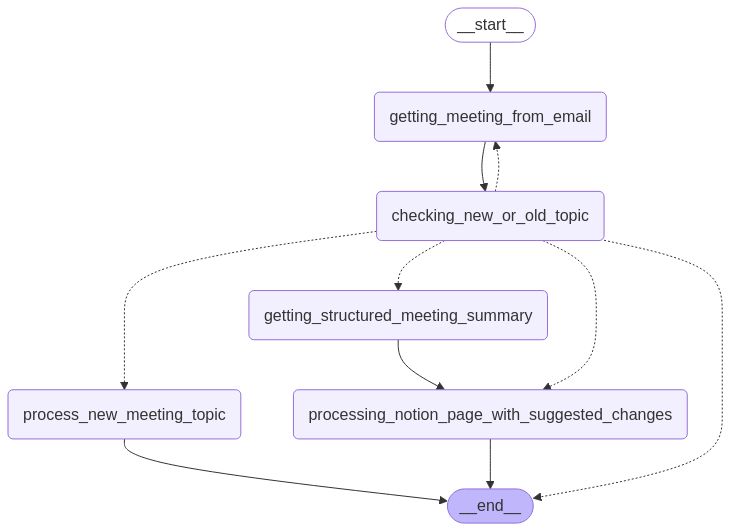

In [14]:
my_agent_builder = StateGraph(MyAgentState1)

#Adding Nodes
my_agent_builder.add_node("getting_meeting_from_email" , getting_meeting_from_email)
my_agent_builder.add_node("checking_new_or_old_topic" , checking_new_or_old_topic)
# my_agent_builder.add_node("sending_msg_to_admin_via_slack" , sending_msg_to_admin_via_slack)
# my_builder.add_conditional_edges("checking_new_or_old_topic" , decide_new_or_changes)
# my_builder.add_node("getting_latest_meeting_summary" , getting_latest_meeting_summary)
# my_builder.add_node("sending_action_items_to_slack_channel" , sending_action_items_to_slack_channel)
my_agent_builder.add_node("getting_structured_meeting_summary" , getting_structured_meeting_summary)
my_agent_builder.add_node("processing_notion_page_with_suggested_changes" , processing_notion_page_with_suggested_changes)
my_agent_builder.add_node("process_new_meeting_topic" , process_new_meeting_topic)
# my_agent_builder.add_node("messaging_admin_via_slack_for_new_notion_page_id" , messaging_admin_via_slack_for_new_notion_page_id)





# Adding Edges
my_agent_builder.add_edge(START, "getting_meeting_from_email")
my_agent_builder.add_edge("getting_meeting_from_email", "checking_new_or_old_topic")
# adding conditional edge to go to either getting_structured_meeting_summary node or sending_msg_to_admin_via_slack
my_agent_builder.add_conditional_edges("checking_new_or_old_topic", decide_new_or_changes)

# my_builder.add_edge("checking_new_or_old_topic" , "sending_msg_to_admin_via_slack")
# my_builder.add_edge("checking_new_or_old_topic" ,"getting_structured_meeting_summary")
my_agent_builder.add_edge("getting_structured_meeting_summary" , "processing_notion_page_with_suggested_changes")
my_agent_builder.add_edge("processing_notion_page_with_suggested_changes" , END)
my_agent_builder.add_edge("process_new_meeting_topic" , END)
# my_agent_builder.add_edge("messaging_admin_via_slack_for_new_notion_page_id" , END)

# my_builder.add_edge("getting_latest_meeting_summary" , "sending_action_items_to_slack_channel")
# my_builder.add_edge("sending_action_items_to_slack_channel" , "getting_structured_meeting_summary")
# my_builder.add_edge("getting_structured_meeting_summary" , "processing_each_notion_page_with_req_changes")
# my_builder.add_edge("processing_each_notion_page_with_req_changes" , END)


notion_agent_graph = my_agent_builder.compile()

# Visualize the graph
display(Image(notion_agent_graph.get_graph(xray=True).draw_mermaid_png()))


In [15]:


latest_meeting_summary_1 = """
0:00
Attendance and Leave Updates
Bhoopendra Sharma mentioned that Shahzad and Andy would be joining the meeting late, while Nadia Dsilva confirmed that Nadia Dibakar is on leave. The team discussed the functionality of Keka for tracking attendance and expressed a desire to increase engagement by posting more frequently in their communication channels. Bhoopendra suggested that they could use the platform for birthday wishes and other updates.

3:57
Leave Schedules and Communication Plans
Bhoopendra Sharma confirmed he will be out of the office from February 15 to February 23, with some availability on February 14. Nadia Dsilva will be on leave for three days, specifically February 19, 20, and 21. Salmanul Faris mentioned he may take three to four days off during the third week of February, though he is unsure of the exact dates.

6:18
Project Update on Navigation Agent Development
Bhoopendra Sharma and Pritesh Singh focused on finalizing the navigation agent and completing the data side for the POC by the week's end. They highlighted the importance of clear schemas and discussed the classification of output entities, with Pritesh mentioning the need to connect with Faisal for further clarification. Additionally, they noted the challenges with dynamic carousel pages and pop-ups in the agent's functionality.

19:57
Exploring Platforms for Agentic Workflows
Bhoopendra Sharma highlighted that current agentic workflows can be executed on local machines without requiring GPUs, making it suitable for proof of concept. He tasked Baz with researching the best platforms for running these workflows and mentioned the possibility of using AWS services like Lambda and ECS. Pritesh Singh also encouraged team members to contribute their findings and insights on industry practices.

24:26
Discussion on Vector Databases and Indexing Solutions
Shahbaaz Singh inquired about the indexing model being used, to which Pritesh Singh responded that they are currently relying on OpenAI calls without a specific model. Bhoopendra Sharma mentioned the possibility of using LangRaph and highlighted the need for different setups depending on whether data is retained in memory. The conversation also touched on various vector databases, including FAISS, ChromaDB, and Pinecone.

28:36
Project Updates and Task Assignments
Bhoopendra Sharma provided updates on the navigation project and the status of custom cases, with team members Sharad, Nadia, and Salmanul sharing their progress. Pritesh Singh addressed the unresolved issue with Google searches, mentioning a temporary workaround that is currently in use while a more permanent solution is being developed.

Progress on the navigation agent and its completion timeline.
Updates on custom cases and other ongoing projects.
Team members' leave schedules and approvals.
Feedback from the marketing team on redesigned pages.
Issues with Google searches and the need for a permanent solution.
41:42
Updates on Row Model Testing and Project Timelines
Sharad Korekar outlined plans to update the upstream URL to facilitate testing of the row model by the QA team, who will identify issues with specific documents. Bhoopendra Sharma noted that the current focus is on pensions, with no live operations, allowing for a thorough end-to-end completion before moving to the EV project. Additionally, there was a discussion about downgrading the TV and ensuring that necessary changes are made in the dev step function.

46:58
GitHub Access and Agent Development Updates
Bhoopendra Sharma announced that all team members have been added to the GitHub team and urged them to complete their accounts. Keerthi Lakshmi Buchupalli reported that they have finished the documentation and initial steps for their agent, while Ananya Sahu mentioned ongoing work on prompt creation. The team also discussed the need for documentation and integration with Notion APIs for their projects."

"""
latest_meeting_summary_2 = """
    2:23
    High-Level Discussion on Axial Project
    Bhoopendra Sharma led a discussion focused on the Axial project, emphasizing the importance of wrapping up discussions this week to begin development next week. Pritesh Singh was involved in locating and sharing a high-level diagram that outlines the Axial process flow, which was essential for the ongoing conversation.
    8:58
    Overview of XCL and Its Marketplace
    Bhoopendra Sharma introduced XCL, a client that operates as a marketplace for mergers and acquisitions, likening it to a real estate broker. He detailed how the platform allows users to register as either buyers or sellers, facilitating interactions and transactions. The focus is on collecting and validating information about companies on the platform to ensure accurate data for both sides.
    Overview of XCL and its business model
    15:04
    Data Collection and Pipeline Development for XCL
    Bhoopendra Sharma outlined the objectives of the XCL project, focusing on collecting data through news scraping, portfolio member scraping, and social media scraping. He explained the need for an end-to-end pipeline that will handle data in batches, synthesizing information from multiple sources to provide comprehensive profiles for investors and sellers. Pritesh Singh contributed by offering to share company links to aid in the explanation.
    29:22
    Data Collection and Pipeline Overview
    Bhoopendra Sharma outlined the data collection strategy, which includes three verticals: news, portfolio pages, and social media. He noted that while the portfolio section is already developing several agents, the news pipeline currently lacks agents but may require them in the future. The collected data will be processed in batches, and classification will be essential to ensure relevance before final output delivery.
    Data collection methods and processes
    39:10
    News and End-to-End Pipeline Development
    Bhoopendra Sharma discussed the creation of a news pipeline and an end-to-end pipeline that will incorporate news, portfolio members, and social media. Pritesh is responsible for the news pipeline, while Baaz and Sharad will oversee the end-to-end pipeline. The three verticals will share the same input data, producing combined outputs for investors.
    Development of the news pipeline
    44:37
    Discussion on New Agentic Pipeline Development
    Bhoopendra Sharma outlined the responsibilities of team members, including Pritesh, Baaz, and Shahbaaz, in developing a new agentic pipeline. He mentioned the need to connect with the social media team and portfolio members while focusing on the integration of agents into the pipeline. The team is tasked with determining the best platforms and designs for the pipeline, which is still in the early stages of development.
    Roles and responsibilities for the project
"""
latest_meeting_topic_1 = "Hive Reveiws and Demos"
latest_meeting_topic_2 = "Axial Project Pipeline"


latest_action_items_data_1 = """
    Action Items:
    * Pritesh Singh will complete the navigation feature by end of day today.
    * Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.
    * Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.
    * Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.
    * Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.
    * Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.
    * Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.
    * Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.
    """
# agent_response = notion_agent_graph.invoke({"latest_meeting_topic" : latest_meeting_topic_2 , "latest_email_meeting_summary" : latest_meeting_summary_2 , "latest_action_items_data" : latest_action_items_data})
latest_action_items_data_2 = """
    "action_items": [
        {"user": "Bhoopendra Sharma", "task": "Use the specified classification for the data extraction process in the next steps."},
        {"user": "Pritesh Singh", "task": "Share a company link for the buy side and sell side to assist in explaining the project."},
        {"user": "Pritesh Singh", "task": "Lead the development of the news pipeline end-to-end and coordinate with the team."},
        {"user": "Bhoopendra Sharma", "task": "Ensure that documentation is started and information on models is prepared for the project."},
        {"user": "Bhoopendra Sharma", "task": "Set up a call with all stakeholders by Thursday to introduce the team working on the pipeline and discuss support needed."}
    """

# async def main():
#     agent_response = await notion_agent_graph.ainvoke({
#         "latest_meeting_topic": latest_meeting_topic_1,
#         "latest_email_meeting_summary": latest_meeting_summary_1,
#         "latest_action_items_data": latest_action_items_data_1
#     })

async def main(latest_meeting_summary_1):
    # llm to extract latest_meeting_topic_1 and latest_action_items_data_1
    print("🟩🟩🟩🟩 In Agent Invocation   🟩🟩🟩🟩")
    prompt = f"""
    Given the following call summary:
    1. Identify the **title** of this meeting.
    2. Remove any **duplicated sentences** while keeping the content meaningful.
    3. Identify the **stakeholders** in the call:
       - Who is **leading the call**?
       - Who has been **assigned tasks**?
    4. Identify the **action points** in the call and create a table of users and their assigned tasks.

    Call Summary:
    {latest_meeting_summary_1}  # Access as dictionary key

    Provide the output **strictly in JSON format**, without any extra text.

    Example:
    {{
        "meeting_title": "Project Budget Review",
        "cleaned_summary": "A cleaned whole meeting summary text",
        "stakeholders": {{
            "leader": "John Doe",
            "task_assignees": ["Alice", "Bob"]
        }},
        "action_items": [
            {{"user": "Alice", "task": "Prepare budget report"}},
            {{"user": "Bob", "task": "Review funding options"}}
        ]
    }}
    """
    llm_response = llm.invoke(prompt)
    llm_response_content = llm_response.content
    # print(llm_response_content)
    cleaned_json_str = re.sub(r'^```json\n|\n```$', '', llm_response_content.strip())
    print(cleaned_json_str)
    over_all_meeting_structured_info = json.loads(cleaned_json_str)
    latest_meeting_topic_1 = over_all_meeting_structured_info.get("meeting_title")
    cleaned_meeting_summary_1 = over_all_meeting_structured_info.get("cleaned_summary")
    latest_action_items_data_1 = over_all_meeting_structured_info.get("action_items")
    print(latest_meeting_topic_1)
    print(cleaned_meeting_summary_1)
    print(latest_action_items_data_1)
    print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&***************************************************&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")


    agent_response = await notion_agent_graph.ainvoke({
        "latest_meeting_topic": latest_meeting_topic_1,
        "latest_email_meeting_summary": latest_meeting_summary_1,
        "latest_action_items_data": latest_action_items_data_1
    })



    print(" Agent Response:", agent_response)

# await main()

In [ ]:
import os
import asyncio
from slack_sdk.socket_mode.aiohttp import SocketModeClient  # Async Socket Mode Client
from slack_sdk.web.async_client import AsyncWebClient  # Async WebClient
from slack_sdk.socket_mode.response import SocketModeResponse
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")  # Bot Token (xoxb-...)
APP_LEVEL_TOKEN = os.getenv("SLACK_APP_TOKEN")  # App Token (xapp-...)
READ_AI_CHANNEL_ID = os.getenv("READ_AI_CHANNEL_ID")  # Slack channel ID

# Slack Clients (Async)
slack_client = AsyncWebClient(token=SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=APP_LEVEL_TOKEN, web_client=slack_client)

# Store processed message IDs to avoid duplicates
processed_messages = set()

async def handle_event(payload):
    """Handles incoming Slack messages and extracts Read.ai summaries."""
    event = payload.get("event", {})

    # Extract unique message ID (Slack timestamp)
    message_id = event.get("ts")  # Slack's unique message timestamp
    if not message_id:
        print("⚠️ Message ID missing, skipping event.")
        return  

    # Check if the message is from the correct channel
    if event.get("type") == "message" and event.get("channel") == READ_AI_CHANNEL_ID:
        
        if message_id in processed_messages:
            print(f"⚠️ Duplicate event ignored: {message_id}")
            return  # Ignore duplicate event
        
        user = event.get("user", "")
        text = event.get("text", "").strip()  # Extract message text

        if text and user:  # Ensure the message has text and a sender
            latest_summary = text  # Store the summary in the variable
            print(f"📜 Read.ai Summary Detected & Stored: {latest_summary}")
            
            # ✅ Run `main()` in a separate async task
            asyncio.create_task(run_main(latest_summary))

            processed_messages.add(message_id)  # ✅ Store message ID **before** running `main()`

        else:
            print("⚠️ No text found in message.")

async def run_main(latest_summary):
    """Runs main() in a separate task to avoid blocking."""
    try:
        await main(latest_summary)
    except Exception as e:
        print(f"⚠️ Error in main(): {e}")

async def start_socket_client():
    """Starts the Slack Socket Mode client asynchronously."""
    @socket_client.socket_mode_request_listeners.append
    async def on_event_request(client: SocketModeClient, req: SocketModeRequest):
        """Listener for Slack Socket Mode events."""
        if req.type == "events_api":
            await handle_event(req.payload)  # Await the async function
            
            # Acknowledge the request using SocketModeResponse
            response = SocketModeResponse(envelope_id=req.envelope_id)
            await client.send_socket_mode_response(response)

    print("Listening for Read.ai summaries in Slack...")
    await socket_client.connect()

# Start listening
if __name__ == "__main__":
    try:
        loop = asyncio.get_running_loop()
        loop.create_task(start_socket_client())  # ✅ Use create_task() if already running
    except RuntimeError:
        asyncio.run(start_socket_client())  # ✅ Use asyncio.run() if no event loop exists


Listening for Read.ai summaries in Slack...
2025-03-12 12:51:55,748 - INFO - A new session (s_110205221019) has been established
📜 Read.ai Summary Detected & Stored: Meeting title is Weekly Retrospective and Sprint planning
[10:58 AM] ganesh.​putta

Meeting summary is
Overview
The meeting focused on improving task management and documentation practices within the team. Bhoopendra Sharma emphasized the importance of breaking down tasks into smaller, manageable units and closing them regularly. The team discussed the Excel project, targeting 200 new cases for next week to mature the agent and improve delivery. They also covered updates on the BlackRock project, IDP agent integration, and data store work. Senthil Kumar was tasked with completing the IDP agent integration and improving the UI for better user experience. The team also discussed infrastructure issues, including a billing discrepancy with AWS and a cleanup task for IDP that was blocked due to pending model training on pension

In [1]:
socket_client.disconnect()

NameError: name 'socket_client' is not defined

In [ ]:
"""
from notion_api_tools import update_block_content , delete_block , append_bulleted_list_to_block , append_toggle_with_bullets_for_change_log

from datetime import datetime
def process_changes(data_list):
    today_date = datetime.today().strftime('%Y-%m-%d')
    
    for entry in data_list:
        page_id = entry.get("page_id")
        changes = entry.get("changes", [])
        change_logs = entry.get("changeLogs", [])
        
        for change in changes:
            block_id = change.get("objectId")
            change_type = change.get("ChangeType")
            content = change.get("ContentForChange")
            
            if change_type == "update":
                update_block_content.invoke(input = { "updating_block_info"  :  {"blockId": block_id, "new_text_content": content}})
            elif change_type == "delete":
                delete_block.invoke(input = {"deleting_block_info" : {"blockId": block_id}})  
            elif change_type == "append":
                append_bulleted_list_to_block.invoke(input = {"adding_content_info" : {"blockId": block_id, "bullet_points_list": [content]}})
        
        if change_logs:
            append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                "NOTION_PAGE_ID": page_id,
                "toggle_item_text": f"Change Log {today_date}",
                "bullet_points_list": change_logs
            }})
"""
"""
data_list = [
    {
        "page_id": "18ae35223beb804fbfb3cce77e9a94fb",
        "changes": [
            {
                "LineId": "5.5.1.1",
                "objectId": "18be3522-3beb-80a1-ad55-fbe11468e930",
                "ChangeType": "update",
                "function_to_be_used": "update_content",
                "ContentForChange": "Objective to expand to ~500,000 companies (original scope updated in Change Log)."
            },
            {
                "LineId": "5.6.3.2.1",
                "objectId": "18be3522-3beb-80e0-a5e2-ec955ac2316a",
                "ChangeType": "append",
                "function_to_be_used": "append_content",
                "ContentForChange": "Current schema has been changed by Pritesh and final consolidated output is edited in Google Sheet."
            },
            {
                "LineId": "5.6.3.2.2",
                "objectId": "18be3522-3beb-8054-aad1-cdd379b676b7",
                "ChangeType": "append",
                "function_to_be_used": "append_content",
                "ContentForChange": "Current schema and final consolidated output schema in Google Sheets."
            },
            {
                "LineId": "5.6.3.3",
                "objectId": "18be3522-3beb-807d-9843-ff07bf214744",
                "ChangeType": "append",
                "function_to_be_used": "append_content",
                "ContentForChange": "Bhoopendra Sharma will share the Notion page with Divakar to consolidate information."
            }
        ],
        "changeLogs": [
            "Updated the expansion objective to ~500,000 companies per the latest meeting summary.",
            "Appended discussion points about the schema and consolidated outputs in Google Sheets."
        ],
        "suggested_action_items_add": [
            {
                "action_item_text": "Pritesh Singh will complete the navigation feature by end of day today.",
                "assignees": [
                    "Pritesh Singh"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.",
                "assignees": [
                    "Keerthi Lakshmi Buchupalli"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.",
                "assignees": [
                    "Ganesh Putta"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.",
                "assignees": [
                    "Ganesh Putta"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.",
                "assignees": [
                    "Pritesh Singh"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.",
                "assignees": [
                    "Pritesh Singh"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.",
                "assignees": [
                    "Bhoopendra Sharma"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.",
                "assignees": [
                    "Ananya Sahu",
                    "Vaibhav Thakran"
                ],
                "status": "In Progress"
            }
        ]
    },
    {
        "page_id": "196e35223beb806a8889f2524d28bdaf",
        "changes": [
            {
                "LineId": "4.1",
                "objectId": "196e3522-3beb-814b-8fc9-cc1276858729",
                "ChangeType": "update",
                "function_to_be_used": "updateContent",
                "ContentForChange": "Bhoopendra Sharma and Pritesh Singh focused on finalizing the navigation agent and completing the data side for the POC by the week's end. They highlighted the importance of clear schemas and discussed the classification of output entities. Pritesh mentioned the need to connect with Faisal for further clarification. Additionally, they noted the challenges with dynamic carousel pages and pop-ups in the agent's functionality. Progress on navigation feature to be completed by end of day today."
            },
            {
                "LineId": "4.1.2",
                "objectId": "196e3522-3beb-805b-b7d6-d5b356142059",
                "ChangeType": "append",
                "function_to_be_used": "appendContent",
                "ContentForChange": "Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium."
            },
            {
                "LineId": "4.3.1.1",
                "objectId": "196e3522-3beb-8182-9822-dce1fae89c7a",
                "ChangeType": "update",
                "function_to_be_used": "updateContent",
                "ContentForChange": "Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team."
            }
        ],
        "changeLogs": [
            "Updated progress on navigation agent to include completion timeline and added action item regarding SEMrush API integration.",
            "Updated action item for Prabhash\u2019s team to emphasize urgency in domain identification assistance."
        ],
        "suggested_action_items_add": [
            {
                "action_item_text": "Pritesh Singh will complete the navigation feature by end of day today.",
                "assignees": [
                    "Pritesh Singh"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.",
                "assignees": [
                    "Keerthi Lakshmi Buchupalli"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.",
                "assignees": [
                    "Ganesh Putta"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.",
                "assignees": [
                    "Ganesh Putta"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin.",
                "assignees": [
                    "Bhoopendra Sharma"
                ],
                "status": "In Progress"
            },
            {
                "action_item_text": "Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.",
                "assignees": [
                    "Ananya Sahu",
                    "Vaibhav Thakran"
                ],
                "status": "In Progress"
            }
        ]
    }
]
"""
# process_changes(data_list)

objectId is 18be3522-3beb-80a1-ad55-fbe11468e930
new_text_content is Objective to expand to ~500,000 companies (original scope updated in Change Log).
⌛⌛ Getting Object , Please wait ⌛⌛
🟢🟢🟢 Object Arrived , Got Response 🟢🟢🟢
🟢🟢🟢  Found Return Type of Object , Object Type is bulleted_list_item, Returning the Type now 🟢🟢🟢
Retrieving Notion block type for object ID: 18be3522-3beb-80a1-ad55-fbe11468e930
Preparing payload to update block content.
Sending request to update Notion block content...
Content successfully updated in block 18be3522-3beb-80a1-ad55-fbe11468e930.
⌛⌛ Getting Object , Please wait ⌛⌛
🟢🟢🟢 Object Arrived , Got Response 🟢🟢🟢
🟢🟢🟢  Found Return Type of Object , Object Type is bulleted_list_item, Returning the Type now 🟢🟢🟢
Preparing Payload to add content to ObjectId: 18be3522-3beb-80e0-a5e2-ec955ac2316a
Payload Prepared: {'children': [{'object': 'block', 'type': 'bulleted_list_item', 'bulleted_list_item': {'rich_text': [{'type': 'text', 'text': {'content': 'Current schema has 

In [ ]:


# import re
# from notion_api_tools import add_heading_to_page , add_bulleted_list_with_subpoints , append_new_topic_toggle_under_given_toggle_id , append_toggle_to_given_page , append_toggle_with_bullets_for_change_log



# latest_meeting_summary = """
#     2:23
#     High-Level Discussion on Axial Project
#     Bhoopendra Sharma led a discussion focused on the Axial project, emphasizing the importance of wrapping up discussions this week to begin development next week. Pritesh Singh was involved in locating and sharing a high-level diagram that outlines the Axial process flow, which was essential for the ongoing conversation.
#     8:58
#     Overview of XCL and Its Marketplace
#     Bhoopendra Sharma introduced XCL, a client that operates as a marketplace for mergers and acquisitions, likening it to a real estate broker. He detailed how the platform allows users to register as either buyers or sellers, facilitating interactions and transactions. The focus is on collecting and validating information about companies on the platform to ensure accurate data for both sides.
#     Overview of XCL and its business model
#     15:04
#     Data Collection and Pipeline Development for XCL
#     Bhoopendra Sharma outlined the objectives of the XCL project, focusing on collecting data through news scraping, portfolio member scraping, and social media scraping. He explained the need for an end-to-end pipeline that will handle data in batches, synthesizing information from multiple sources to provide comprehensive profiles for investors and sellers. Pritesh Singh contributed by offering to share company links to aid in the explanation.
#     29:22
#     Data Collection and Pipeline Overview
#     Bhoopendra Sharma outlined the data collection strategy, which includes three verticals: news, portfolio pages, and social media. He noted that while the portfolio section is already developing several agents, the news pipeline currently lacks agents but may require them in the future. The collected data will be processed in batches, and classification will be essential to ensure relevance before final output delivery.
#     Data collection methods and processes
#     39:10
#     News and End-to-End Pipeline Development
#     Bhoopendra Sharma discussed the creation of a news pipeline and an end-to-end pipeline that will incorporate news, portfolio members, and social media. Pritesh is responsible for the news pipeline, while Baaz and Sharad will oversee the end-to-end pipeline. The three verticals will share the same input data, producing combined outputs for investors.
#     Development of the news pipeline
#     44:37
#     Discussion on New Agentic Pipeline Development
#     Bhoopendra Sharma outlined the responsibilities of team members, including Pritesh, Baaz, and Shahbaaz, in developing a new agentic pipeline. He mentioned the need to connect with the social media team and portfolio members while focusing on the integration of agents into the pipeline. The team is tasked with determining the best platforms and designs for the pipeline, which is still in the early stages of development.
#     Roles and responsibilities for the project
# """
# prompt = f"""
# You are an advanced AI assistant that organizes meeting summaries into a structured hierarchical JSON format.
#     ## **Task:**
#     You will receive a `latest_meeting_summary`, which consists of meeting topics divided by timestamps. Your task is to convert this summary into a structured JSON format following this hierarchy:
#     ### **Expected JSON Structure:**
#     {{
#         "latest_notes": [
#             {{
#                 "topic": "<Main Topic>",
#                 "sub_topics": [
#                     {{
#                         "sub_topic": "<Sub-topic>",
#                         "bullet_points": [
#                             "<Key point 1>",
#                             "<Key point 2>",
#                             "<Key point 3>"
#                         ]
#                     }}
#                 ]
#             }}
#         ]
#     }}
#     ## **Instructions:**
#     1. **Extract Topics**: Identify distinct topics based on timestamps.
#     2. **Extract Sub-Topics**: Within each topic, identify key sub-topics.
#     3. **Extract Bullet Points**: Break down each sub-topic into concise bullet points.
#     4. **Ensure Readability**: The JSON should be well-structured and easy to interpret.
#     ## **Input:**
#     {latest_meeting_summary}
#     ## **Output Format:**
#     - Return only the structured JSON.
#     - Maintain logical hierarchy: **Topic → Sub-Topic → Bullet Points**.
#     - Ensure accuracy and meaningful grouping.
# """
# llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=openai_api_key)


# llm_response = llm.invoke(prompt)
# response_content = llm_response.content
# cleaned_response_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())

# new_topic_json_data = json.loads(cleaned_response_str)

# latest_notes = new_topic_json_data.get("latest_notes")
# print(latest_notes)







2025-02-13 09:29:55,891 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[{'topic': 'High-Level Discussion on Axial Project', 'sub_topics': [{'sub_topic': 'Discussion Leadership', 'bullet_points': ['Led by Bhoopendra Sharma.', 'Emphasized the importance of wrapping up discussions this week.', 'Development is set to begin next week.']}, {'sub_topic': 'Process Flow Diagram', 'bullet_points': ['Pritesh Singh shared a high-level diagram.', 'Essential for ongoing conversation about the Axial project.']}]}, {'topic': 'Overview of XCL and Its Marketplace', 'sub_topics': [{'sub_topic': 'Introduction to XCL', 'bullet_points': ['Operates as a marketplace for mergers and acquisitions.', 'Similar to a real estate broker model.', 'Users can register as buyers or sellers.']}, {'sub_topic': 'Data Accuracy', 'bullet_points': ['Focus on collecting and validating company information.', 'Ensures accurate data for both buyers and sellers.']}]}, {'topic': 'Data Colle

In [ ]:
# Researching


from notion_api_tools import add_heading_to_page , add_bulleted_list_with_subpoints , append_new_topic_toggle_under_given_toggle_id , append_toggle_to_given_page , append_toggle_with_bullets_for_change_log
from datetime import datetime

today_date = datetime.today().strftime('%Y-%m-%d')

def applying_new_topics_in_new_notion_page(notion_page_id , latest_notes_list):

    # step-1 :-  Applying Heading
    add_heading_to_page(notion_page_id , "This is related to Change Log")

    #step-2 :-  adding Toggle with Chaneg Log
    append_toggle_with_bullets_for_change_log.invoke(input = {"addingToggleItemInfo" : {
                "NOTION_PAGE_ID": notion_page_id,
                "toggle_item_text": f"Change Log {today_date}",
                "bullet_points_list": ["Added all new Topics"]
            }})

    # step-3 :- 
    latest_notes_toggle_block_id = append_toggle_to_given_page(notion_page_id , "Latest Notes")

    # Appending all topic blocks as children to latest_notes_toggle_block_id

    for each_topic_element in latest_notes_list:
        topic_name = each_topic_element.get("topic")
        sub_topics_list = each_topic_element.get("sub_topics")   # sub_topics_list is a list
        
        topic_toggle_block_id = append_new_topic_toggle_under_given_toggle_id(latest_notes_toggle_block_id , topic_name)

        # appending each-sub-topics with corresponding bullets
        # each_sub_topic has sub_topic name and bullet_points
        
        add_bulleted_list_with_subpoints(topic_toggle_block_id ,sub_topics_list)


# latest_notes_content = {
    
#     "latest_notes": [
#         {
#             "topic": "High-Level Discussion on Axial Project",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Project Overview",
#                     "bullet_points": [
#                         "Importance of concluding discussions this week.",
#                         "Development to commence next week.",
#                         "High-level diagram provided by Pritesh Singh to outline the process flow."
#                     ]
#                 }
#             ]
#         },
#         {
#             "topic": "Overview of XCL and Its Marketplace",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Introduction to XCL",
#                     "bullet_points": [
#                         "XCL operates as a marketplace for mergers and acquisitions.",
#                         "Functionality allows users to register as buyers or sellers.",
#                         "Focus on collecting and validating company information for accurate data."
#                     ]
#                 },
#                 {
#                     "sub_topic": "Business Model",
#                     "bullet_points": [
#                         "Likened to a real estate broker.",
#                         "Facilitates interactions and transactions in M&A.",
#                         "Ensures data accuracy for both buyers and sellers."
#                     ]
#                 }
#             ]
#         },
#         {
#             "topic": "Data Collection and Pipeline Development for XCL",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Data Collection Objectives",
#                     "bullet_points": [
#                         "Focus on data collection through news, portfolio, and social media scraping.",
#                         "Need for an end-to-end pipeline to handle data in batches.",
#                         "Aims to provide comprehensive profiles for investors and sellers."
#                     ]
#                 },
#                 {
#                     "sub_topic": "Contributions from Team Members",
#                     "bullet_points": [
#                         "Pritesh Singh offered to share company links for clarity."
#                     ]
#                 }
#             ]
#         },
#         {
#             "topic": "Data Collection and Pipeline Overview",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Data Collection Strategy",
#                     "bullet_points": [
#                         "Includes three verticals: news, portfolio pages, and social media.",
#                         "Portfolio section has some agent development.",
#                         "News pipeline currently lacks agents but may require them in the future."
#                     ]
#                 },
#                 {
#                     "sub_topic": "Processing and Classification",
#                     "bullet_points": [
#                         "Data to be processed in batches.",
#                         "Classification to ensure relevance before final output delivery."
#                     ]
#                 }
#             ]
#         },
#         {
#             "topic": "News and End-to-End Pipeline Development",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Pipeline Responsibilities",
#                     "bullet_points": [
#                         "Pritesh responsible for the news pipeline.",
#                         "Baaz and Sharad overseeing the end-to-end pipeline.",
#                         "Verticals will share the same input data for combined outputs."
#                     ]
#                 }
#             ]
#         },
#         {
#             "topic": "Discussion on New Agentic Pipeline Development",
#             "sub_topics": [
#                 {
#                     "sub_topic": "Team Roles and Responsibilities",
#                     "bullet_points": [
#                         "Bhoopendra assigned roles for Pritesh, Baaz, and Shahbaaz.",
#                         "Need to connect with social media team and portfolio members.",
#                         "Focus on integrating agents into the pipeline, still in early development phase."
#                     ]
#                 },
#                 {
#                     "sub_topic": "Design Considerations",
#                     "bullet_points": [
#                         "Team to determine best platforms for the pipeline.",
#                         "Discussions on pipeline designs underway."
#                     ]
#                 }
#             ]
#         }
#     ]
# }
# new_notion_page_id = "199e35223beb80a2b7aaca61e9bbade0"
# applying_new_topics_in_new_notion_page(new_notion_page_id ,latest_notes_content.get("latest_notes"))



✅ Heading block added successfully! ID: 199e3522-3beb-819f-a050-e8c5edd88507
TOGGLE INFO
{'NOTION_PAGE_ID': '199e35223beb80a2b7aaca61e9bbade0', 'toggle_item_text': 'Change Log 2025-02-13', 'bullet_points_list': ['Added all new Topics']}
&&&&&&&&&*******************&&&&&&&&&&&
🧑‍🏭 Initiating toggle item addition. Fetching first child object ID from the given Notion page ID.
⌛ Requesting to get the first child data...
🟩 Response received.
🟢 Found first child block ID: 199e3522-3beb-80e3-a20b-d00b288d24f8
🔄 Creating a new toggle item before block ID: 199e3522-3beb-80e3-a20b-d00b288d24f8
⌚ Requesting to add a new Toggle Item ⌚
⌚ Requesting to add Toggle Item after ObjectId: 199e3522-3beb-80e3-a20b-d00b288d24f8 ⌚
🟢 Toggle Item added successfully! Toggle ID: 199e3522-3beb-8102-8f84-c1ab48ee09b5
🆕 New toggle item created with ID: 199e3522-3beb-8102-8f84-c1ab48ee09b5
🧑‍🏭 Adding bullet points to the newly created toggle item...
⌛⌛ Getting Object , Please wait ⌛⌛
🟢🟢🟢 Object Arrived , Got Respons

In [7]:
# Experimentation (comparing latest Meeting summamry with previous meeting summary)
previous_meeting_summary = """
0:00
Attendance and Leave Updates
Bhoopendra Sharma mentioned that Shahzad and Andy would be joining the meeting late, while Nadia Dsilva confirmed that Nadia Dibakar is on leave. The team discussed the functionality of Keka for tracking attendance and expressed a desire to increase engagement by posting more frequently in their communication channels. Bhoopendra suggested that they could use the platform for birthday wishes and other updates.

3:57
Leave Schedules and Communication Plans
Bhoopendra Sharma confirmed he will be out of the office from February 15 to February 23, with some availability on February 14. Nadia Dsilva will be on leave for three days, specifically February 19, 20, and 21. Salmanul Faris mentioned he may take three to four days off during the third week of February, though he is unsure of the exact dates.

6:18
Project Update on Navigation Agent Development
Bhoopendra Sharma and Pritesh Singh focused on finalizing the navigation agent and completing the data side for the POC by the week's end. They highlighted the importance of clear schemas and discussed the classification of output entities, with Pritesh mentioning the need to connect with Faisal for further clarification. Additionally, they noted the challenges with dynamic carousel pages and pop-ups in the agent's functionality.

19:57
Exploring Platforms for Agentic Workflows
Bhoopendra Sharma highlighted that current agentic workflows can be executed on local machines without requiring GPUs, making it suitable for proof of concept. He tasked Baz with researching the best platforms for running these workflows and mentioned the possibility of using AWS services like Lambda and ECS. Pritesh Singh also encouraged team members to contribute their findings and insights on industry practices.

24:26
Discussion on Vector Databases and Indexing Solutions
Shahbaaz Singh inquired about the indexing model being used, to which Pritesh Singh responded that they are currently relying on OpenAI calls without a specific model. Bhoopendra Sharma mentioned the possibility of using LangRaph and highlighted the need for different setups depending on whether data is retained in memory. The conversation also touched on various vector databases, including FAISS, ChromaDB, and Pinecone.

28:36
Project Updates and Task Assignments
Bhoopendra Sharma provided updates on the navigation project and the status of custom cases, with team members Sharad, Nadia, and Salmanul sharing their progress. Pritesh Singh addressed the unresolved issue with Google searches, mentioning a temporary workaround that is currently in use while a more permanent solution is being developed.

Progress on the navigation agent and its completion timeline.
Updates on custom cases and other ongoing projects.
Team members' leave schedules and approvals.
Feedback from the marketing team on redesigned pages.
Issues with Google searches and the need for a permanent solution.
41:42
Updates on Row Model Testing and Project Timelines
Sharad Korekar outlined plans to update the upstream URL to facilitate testing of the row model by the QA team, who will identify issues with specific documents. Bhoopendra Sharma noted that the current focus is on pensions, with no live operations, allowing for a thorough end-to-end completion before moving to the EV project. Additionally, there was a discussion about downgrading the TV and ensuring that necessary changes are made in the dev step function.

46:58
GitHub Access and Agent Development Updates
Bhoopendra Sharma announced that all team members have been added to the GitHub team and urged them to complete their accounts. Keerthi Lakshmi Buchupalli reported that they have finished the documentation and initial steps for their agent, while Ananya Sahu mentioned ongoing work on prompt creation. The team also discussed the need for documentation and integration with Notion APIs for their projects."

"""
latest_meeting_summary_1 = """
0:01
Sprint Review and Progress Update
Bhoopendra Sharma mentioned that some team members were unavailable for the call, including Bhaj due to a family issue. The meeting aimed to review the progress of the sprint, with Pritesh discussing the current status of the navigation feature. Pritesh explained the challenges he faced and the solutions he was implementing to improve the agent's functionality.

Progress on the navigation feature and its completion timeline.
8:14
Pipeline Development and Team Involvement
Bhoopendra Sharma highlighted the urgency of starting discussions on the Excel pipeline, which consists of news and end-to-end components. He proposed that Pritesh Singh lead the preparation of a demo to provide visibility on the pipelines for the team, particularly for new members. The goal is to ensure everyone understands the pipeline concepts and can apply them in future projects.

11:45
Progress on Marketing Agent Development
Bhoopendra Sharma and Keerthi Lakshmi Buchupalli reviewed the progress on the marketing agent, particularly the integration of SEMrush and other SEO tools. Keerthi mentioned encountering an error with the SEMrush API and proposed using Selenium for development. Bhoopendra agreed and emphasized the importance of creating a module that can interact with SEMrush while continuing to develop the agent.

Integration of SEMrush API and the use of Selenium for the marketing agent.
16:09
Notion Integration and Documentation Updates
Bhoopendra Sharma emphasized the need to make progress on the Notion integration for documentation. Ganesh Putta reported on his discussions with Baaz and his exploration of Notion's APIs, detailing the process of creating action items and managing documents. They identified the need for additional tools to update existing pages and maintain change logs.

Updates on the documentation agent and Notion API exploration.
21:34
Progress on IDP Agent Development
Ananya Sahu reported on her progress with the IDP agent, explaining the steps taken to convert a PDF into images and then into CSV format, while noting the need for further optimization. Bhoopendra Sharma responded by highlighting the importance of creating an agentic flow that includes human interaction for error correction and the potential to enhance the tools used for image processing. He pointed out that the current approach is too static and requires a more dynamic workflow.

27:56
API Key Distribution and Project Updates
Ananya Sahu faced difficulties acquiring a free API key for OpenAI, but Bhoopendra Sharma assured that keys were available for all team members. Pritesh Singh confirmed he would share a key intended for researchers. Additionally, Ananya provided an update on her connection with Devakar regarding the production server link and code review.

31:12
IDP Agent Development Discussion
Vaibhav Thakran presented the current state of the IDP agent, explaining how it processes images and extracts table data, albeit with some accuracy challenges. Bhoopendra Sharma pointed out that the agent's reliance on OpenAI models may limit its effectiveness and suggested incorporating a human-in-the-loop approach to enhance its capabilities. He also mentioned the importance of developing custom tools within the framework being used.

Development and enhancements of the IDP agent with a focus on human-in-the-loop design.
37:59
Updates on Agent Development and Project Deadlines
Bhoopendra Sharma addressed the status of agent assignments, assuring Diwakar Joshi that he would receive an agent despite previous setbacks. Salmanul Faris reported delays in the BLK project, noting that the team is behind schedule on completing the required URLs. Bhoopendra emphasized the importance of familiarizing the team with new agent technologies and tools.

Overall team readiness and comfort with agentic frameworks and tools.

"""
# action_items =  """"""

print("Getting a Structured Refined Summary from an LLM in the form of a List of Dicts")
print("Getting existing Notion Pages Content")
pages_id_list = ["18ae35223beb804fbfb3cce77e9a94fb" , "196e35223beb806a8889f2524d28bdaf"]
# notion_pages = [
#     # {"page_id": "18ae35223beb804fbfb3cce77e9a94fb", "fetched_content": ""},
#     # {"page_id": "196e35223beb806a8889f2524d28bdaf", "fetched_content": "Extracted content for Notion Page 2..."}
# ]
notion_pages_data = []
# overall_notion_data  = ""
for eachPageId in pages_id_list:
    each_dict = dict()
    each_dict["page_id"] = eachPageId
    each_dict["fetched_content"] = str(fetch_notion_page_content.invoke(input = {"notion_page_id_info" : {"notion_page_id" :eachPageId }} ))
    print("🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢")
    # print(each_dict["fetched_content"])
    notion_pages_data.append(each_dict)

all_page_changes = []
for page in notion_pages_data:
    fetched_content = page["fetched_content"]
    print(fetched_content)
    page_id = page["page_id"]
    action_items = """"
    Action Items:
    * Pritesh Singh will complete the navigation feature by end of day today.
    * Keerthi Lakshmi Buchupalli will start integrating the SEMrush API using Selenium.
    * Ganesh Putta will create action items based on the discussed flow diagram after connecting with Baaz and exploring Notion integrations.
    * Ganesh Putta will explore the Notion API further and provide a sample page for the documentation agent.
    * Pritesh Singh will prepare a quick demo of the current EIP pipeline for the team.
    * Pritesh Singh will share the key created by Neha for researchers with everyone involved in agentic work to ensure consistency.
    * Bhoopendra Sharma will connect with the marketing team to understand their requirements for integrating the oxygen plugin and schedule a meeting with Punit.
    * Ananya Sahu and Vaibhav Thakran will work on enhancing the IDP agent to include a human-in-the-loop concept.
    """
    prompt = f"""
    You are an Intelligent Agent.
    You are working with content from a Notion Page. Your goal is to analyze the **Latest Meeting Summary**, the **Previous Meeting Summary**, and compare them with the **Extracted Content** (which is from each Notion Page) to identify required changes that should be made in the Extracted Content.
    
    Additionally, you must analyze the **Action Items** and compare them with the **Extracted Content**. If any action item is relevant to a section in the extracted content, it should be added to a list called **"suggested_action_items_add"**.

    ---
    ### **Structure of Each Notion Page Content**
    Each Notion Page consists of the following **Main Sections**:
    1. **ChangeLog** → A record of past modifications to the page.
       - The **ChangeLog section** can be identified by entries in the following format:
         `"Change Log - Date: 02/05/2025: {{id: 18be3522-3beb-80bb-9ed9-db0db98e9c3b}}"`
       - Each entry contains a **date** and a **unique identifier (UUID)** that tracks modifications.
    2. **Latest Notes** → Contains multiple **topics related to the project**.  
       - All content under this section **belongs to Latest Notes**.  
       - These topics are structured **hierarchically** and follow a numerical outline format.  
       - The **ChangeLog** will have its own numbering (e.g., **2, 3, 4, etc.**) and is separate from **Latest Notes**.  
       - If **Latest Notes** starts at line **6**, then topics will follow a hierarchical structure:  
           - **Topics:** 6.1, 6.2, 6.4, etc.  
           - **Subtopics under topics:** 6.1.1, 6.1.2, 6.2.1, 6.2.2, 6.4.1, 6.4.2, etc.  
       - Each topic represents a **key discussion point from past meetings**.  
       - **If a topic name needs to be modified, ensure that the new topic name is clear, concise, and does not contain lengthy sentences.**  
       - The topic name should be **short, relevant, and to the point**, avoiding unnecessary details.  
    3. **Action Items (within Latest Notes)** → The last part of the **Latest Notes** contains actionable tasks written in:
       - **Sentence format** (e.g., "Update the API documentation.")
       - **Bullet points** (e.g., "- Finalize testing for module X.")
    
    ---
    ### **How You Should Analyze and Compare the Data**
    - Compare **each topic in Latest Notes** with the corresponding topic in **Latest Meeting Summary**.
    - Compare **Previous Meeting Summary** with **Latest Meeting Summary** to track progress and detect major updates.
    - Identify **inconsistencies, missing updates, or outdated information**.
    - If the **Latest Meeting Summary** provides updates for a specific topic, modify the **Latest Notes** accordingly.
    - When modifying **topic names**, ensure they remain **concise, clear, and understandable** without lengthy explanations.
    - If the **Previous Meeting Summary** contained significant updates (e.g., "Project has started"), check whether there is an important new update in the **Latest Meeting Summary**.
        - If found, add an entry to the **ChangeLog** indicating the progress (e.g., "Project moved from 'Started' to 'In Progress'").
    - Analyze the **Action Items list** from the meeting summary and ensure **relevant action items** are present at the **end of Latest Notes**.

    ---
    ### **Extracted Content (Notion Page)**
    {fetched_content}
    ---
    ### **Previous Meeting Summary (Reference)**
    {previous_meeting_summary}
    ---
    ### **Latest Meeting Summary (Timestamp-based Topics)**
    {latest_meeting_summary_1}
    ---
    ### **Latest Action Items**
    {action_items}
    ---
    ### **Output Format**
    Return a **JSON object** where each Notion Page has:
    - **"changes"** → A list of JSON objects containing all modifications to be applied.
    - **"changeLogs"** → A separate list of human-readable descriptions of what changed.
    - **"suggested_action_items_add"** → A list of dictionaries, where each dictionary contains:
        - `"action_item_text"` → The action item task text.
        - `"assignees"` → A list of names of the people assigned to the task.
        - `"status"` → The status of the task (default is `"In Progress"` if no status is specified).
    
    ```json
    {{
        "page_id": "{page_id}",
        "changes": [
            {{
                "LineId": "<lineid>",
                "objectId": "<ObjectId of the line with LineId>",
                "ChangeType": "<add, append, update, delete>",
                "function_to_be_used": "<function name according to ChangeType>",
                "ContentForChange": "<New content that needs to be modified or added.>"
            }}
        ],
        "changeLogs": [
            "<Human-readable log entry describing the change>"
        ],
        "suggested_action_items_add": [
            {{
                "action_item_text": "<Action item task>",
                "assignees": ["<Assignee Name 1>", "<Assignee Name 2>"],
                "status": "In Progress"
            }}
        ]
    }}
    ```
"""

    # Call the LLM with the prompt (replace with your actual LLM API call)
    response = llm.invoke(prompt)  
    response_content = response.content
    # Clean the response (remove markdown `json` formatting if any)
    cleaned_json_str = re.sub(r'^```json\n|\n```$', '', response_content.strip())
    # Parse the JSON response
    try:
        json_data = json.loads(cleaned_json_str)
        page_changes = {
            "page_id": page_id,
            "changes": json_data.get("changes", []),
            "changeLogs": json_data.get("changeLogs", []),
            "suggested_action_items_add" : json_data.get("suggested_action_items_add" , [])
        }
        print(page_changes)
        all_page_changes.append(page_changes)  # Append each page's changes
        print("Changes extraction completed , waiting for a period")
        time.sleep(3)
        print("Waiting completed")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for page {page_id}: {e}")
print(all_page_changes)

Getting a Structured Refined Summary from an LLM in the form of a List of Dicts
Getting existing Notion Pages Content
🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢
🟢🟢🟢   🟢🟢🟢  fetching one page data is completed 🟢🟢🟢  🟢🟢🟢
1 - This is related to Change Logs {id: 18be3522-3beb-80f8-895a-d12d4f655862}
2 - Change Log 2025-02-13 {id: 199e3522-3beb-81c6-9c89-f007217d7af0}
2.1 - Updated Bhoopendra Sharma's action item to reflect that he will connect with the marketing team for the oxygen plugin integration and schedule a meeting with Punit. {id: 199e3522-3beb-81f0-bd44-d03165eb3b69}
2.2 - Deleted redundant action item regarding Bhoopendra Sharma's connection with the marketing team concerning the oxygen plugin. {id: 199e3522-3beb-8104-b9f9-c865b8b4a5fb}
2.3 - Deleted duplicate action item regarding sharing the Notion page with Divakar. {id: 199e3522-3beb-8187-8042-f01834e3dc9f}
2.4 - Deleted redundant note about current schema and final consolidated output schema in Google Sheets. {id

In [8]:
print(json.dumps(all_page_changes , indent = 4))

[
    {
        "page_id": "18ae35223beb804fbfb3cce77e9a94fb",
        "changes": [
            {
                "LineId": "9.5.3.3",
                "objectId": "198e3522-3beb-815f-9a42-d6629bbb894b",
                "ChangeType": "update",
                "function_to_be_used": "update",
                "ContentForChange": "Bhoopendra Sharma will connect with the marketing team to understand requirements for integrating the oxygen plugin and schedule a meeting with Punit."
            },
            {
                "LineId": "9.5.1.1",
                "objectId": "18be3522-3beb-80a1-ad55-fbe11468e930",
                "ChangeType": "append",
                "function_to_be_used": "append",
                "ContentForChange": "Develop enhancements for the IDP agent with a focus on human-in-the-loop integration."
            }
        ],
        "changeLogs": [
            "Updated Bhoopendra Sharma's action item to connect with the marketing team regarding the oxygen plugin integra

In [ ]:
#THis is related to doc agent trial

import os
import re
import json
from slack_sdk.socket_mode import SocketModeClient
from slack_sdk.web import WebClient
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables (Set these before running the script)
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")  # Bot User Token (xoxb-...)
APP_LEVEL_TOKEN = os.getenv("SLACK_APP_TOKEN")  # App Token (xapp-...)
READ_AI_CHANNEL_ID = os.getenv("READ_AI_CHANNEL_ID")  # Slack channel ID where Read.ai sends summaries

# Initialize Slack Clients
slack_client = WebClient(token=SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=APP_LEVEL_TOKEN, web_client=slack_client)

# Regex to identify Read.ai summary messages (Optional: Adjust based on Read.ai's format)
SUMMARY_PATTERN = re.compile(r"Meeting Summary|Transcript|Notes", re.IGNORECASE)

def store_summary(summary_text):
    """ Store Read.ai summary text (Modify as needed for database, file storage, etc.) """
    with open("meeting_summaries.txt", "a", encoding="utf-8") as file:
        file.write(summary_text + "\n\n")
    print("Summary stored successfully!")

def handle_event(payload):
    """ Handles incoming Slack events and extracts Read.ai summaries """
    event = payload["event"]

    # Check if event is a message from the Read.ai channel
    if event.get("type") == "message" and event.get("channel") == READ_AI_CHANNEL_ID:
        message_text = event.get("text", "")
        
        # Check if the message is a Read.ai summary
        if SUMMARY_PATTERN.search(message_text):
            print(f"Read.ai Summary Detected: \n{message_text}")
            store_summary(message_text)  # Save the summary
        else:
            print("Message received but does not match Read.ai summary format.")

@socket_client.socket_mode_request_listeners.append
def on_event_request(client: SocketModeClient, req: SocketModeRequest):
    """ Listener for Slack Socket Mode events """
    if req.type == "events_api":
        handle_event(req.payload)
        client.ack(req)  # Acknowledge event

# Start listening for Read.ai summaries
if __name__ == "__main__":
    print("Listening for Read.ai summaries in Slack...")
    socket_client.connect()

Listening for Read.ai summaries in Slack...


Read.ai Summary Detected: 
Meeting Summary is thsi si the overall summary for tpday meetinf
Summary stored successfully!
Read.ai Summary Detected: 
Meeting Summary is thsi si the overall summary for tpday meetinf
Summary stored successfully!
Read.ai Summary Detected: 
Meeting Summary is thsi si the overall summary for tpday meetinf
Summary stored successfully!
Read.ai Summary Detected: 
Meeting Summary is thsi si the overall summary for tpday meetinf
Summary stored successfully!
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
📜 Read.ai Summary Detected: Meeting summary is regarding doc agent documentation
[10:58 AM] ganesh.​putta

Meeting summary is
Overview
The meeting focused on improving task management and documentation practices within the team. Bhoopendra Sharma emphasized the importance of brea

In [15]:
# This is related to Human Loop Axial part

import os
import re
from slack_sdk.socket_mode import SocketModeClient
from slack_sdk.web import WebClient
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")  # Bot Token (xoxb-...)
APP_LEVEL_TOKEN = os.getenv("SLACK_APP_TOKEN")  # App Token (xapp-...)
READ_AI_CHANNEL_ID = os.getenv("READ_AI_CHANNEL_ID")  # Slack channel ID

# Slack Clients
slack_client = WebClient(token=SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=APP_LEVEL_TOKEN, web_client=slack_client)

# Regex for detecting "after_qa_{date}.csv"
CSV_PATTERN = re.compile(r"after_qa_\d{4}-\d{2}-\d{2}\.csv")

def handle_event(payload):
    """Handles incoming Slack events, detects files, and prints filename if matched."""
    event = payload["event"]

    if event.get("type") == "message" and event.get("channel") == READ_AI_CHANNEL_ID:
        if "files" in event:  # Check if a file is attached
            for file in event["files"]:
                file_name = file.get("name", "")
                
                if CSV_PATTERN.match(file_name):  # Check file pattern
                    print(f"✅ Matching File Found: {file_name}")
                    print(f"📥 Message: {event.get('text', '')}")  # Print message with filename
                else:
                    print(f"⏩ Skipping non-matching file: {file_name}")

@socket_client.socket_mode_request_listeners.append
def on_event_request(client: SocketModeClient, req: SocketModeRequest):
    """Listener for Slack Socket Mode events."""
    if req.type == "events_api":
        handle_event(req.payload)
        client.ack(req)  # Acknowledge event

# Start listening
if __name__ == "__main__":
    print("Listening for Read.ai summaries & after_qa CSVs in Slack...")
    socket_client.connect()



Listening for Read.ai summaries & after_qa CSVs in Slack...


📜 Read.ai Summary Detected: Meeting summary is regarding doc agent documentation
[10:58 AM] ganesh.​putta

Meeting summary is
Overview
The meeting focused on improving task management and documentation practices within the team. Bhoopendra Sharma emphasized the importance of breaking down tasks into smaller, manageable units and closing them regularly. The team discussed the Excel project, targeting 200 new cases for next week to mature the agent and improve delivery. They also covered updates on the BlackRock project, IDP agent integration, and data store work. Senthil Kumar was tasked with completing the IDP agent integration and improving the UI for better user experience. The team also discussed infrastructure issues, including a billing discrepancy with AWS and a cleanup task for IDP that was blocked due to pending model training on pensions data.
Shahbaaz Singh
- Set up a meeting with the Commerce team on Tuesday (11th)
- Start implementation with the classification module, then 

In [16]:
socket_client.disconnect()

In [17]:
# This is related to Human Loop Axial detecting csv file with after_qa_{date} files

import os
import re
from slack_sdk.socket_mode import SocketModeClient
from slack_sdk.web import WebClient
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables
AXIAL_SLACK_BOT_TOKEN = os.getenv("AXIAL_SLACK_BOT_TOKEN")  # Bot Token (xoxb-...)
AXIAL_APP_LEVEL_TOKEN = os.getenv("AXIAL_APP_LEVEL_TOKEN")  # App Token (xapp-...)
AXIAL_CHANNEL_ID = os.getenv("AXIAL_CHANNEL_ID")  # Slack channel ID

# Slack Clients
slack_client = WebClient(token=AXIAL_SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=AXIAL_APP_LEVEL_TOKEN, web_client=slack_client)

# Regex for detecting "after_qa_{date}.csv"
CSV_PATTERN = re.compile(r"after_qa_\d{4}-\d{2}-\d{2}\.csv")

def handle_event(payload):
    """Handles incoming Slack events, detects files, and prints filename if matched."""
    event = payload["event"]

    if event.get("type") == "message" and event.get("channel") == AXIAL_CHANNEL_ID:
        if "files" in event:  # Check if a file is attached
            for file in event["files"]:
                file_name = file.get("name", "")
                
                if CSV_PATTERN.match(file_name):  # Check file pattern
                    print(f"✅ Matching File Found: {file_name}")
                    print(f"📥 Message: {event.get('text', '')}")  # Print message with filename
                else:
                    print(f"⏩ Skipping non-matching file: {file_name}")

@socket_client.socket_mode_request_listeners.append
def on_event_request(client: SocketModeClient, req: SocketModeRequest):
    """Listener for Slack Socket Mode events."""
    if req.type == "events_api":
        handle_event(req.payload)
        client.ack(req)  # Acknowledge event

# Start listening
if __name__ == "__main__":
    print("Listening for after_qa CSVs in Slack...")
    socket_client.connect()

Listening for after_qa CSVs in Slack...


✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 

📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 
✅ Matching File Found: after_qa_2024-03-10.csv
📥 Message: 


In [ ]:
import os
import re
import boto3
import requests
from slack_sdk.socket_mode import SocketModeClient
from slack_sdk.web import WebClient
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables
AXIAL_SLACK_BOT_TOKEN = os.getenv("AXIAL_SLACK_BOT_TOKEN")
AXIAL_APP_LEVEL_TOKEN = os.getenv("AXIAL_APP_LEVEL_TOKEN")
AXIAL_CHANNEL_ID = os.getenv("AXIAL_CHANNEL_ID")

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME")
S3_FOLDER_NAME = os.getenv("S3_FOLDER_NAME", "slack-uploads")  # Default folder

# Initialize Slack & AWS S3 Clients
slack_client = WebClient(token=AXIAL_SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=AXIAL_APP_LEVEL_TOKEN, web_client=slack_client)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION,
)

# Regex for detecting "after_qa_{date}.csv"
CSV_PATTERN = re.compile(r"after_qa_\d{4}-\d{2}-\d{2}\.csv")


def stream_file_to_s3(file_url, file_name):
    """Streams file from Slack directly to S3 without saving locally."""
    headers = {"Authorization": f"Bearer {AXIAL_SLACK_BOT_TOKEN}"}
    response = requests.get(file_url, headers=headers, stream=True)

    if response.status_code == 200:
        s3_key = f"{S3_FOLDER_NAME}/{file_name}"
        try:
            s3_client.upload_fileobj(response.raw, S3_BUCKET_NAME, s3_key)
            print(f"✅ File streamed to S3: s3://{S3_BUCKET_NAME}/{s3_key}")
        except Exception as e:
            print(f"❌ S3 Upload Failed: {e}")
    else:
        print(f"❌ File streaming failed: {response.status_code}")


def handle_event(payload):
    """Handles incoming Slack events, detects files, and streams them to S3."""
    event = payload["event"]

    if event.get("type") == "message" and event.get("channel") == AXIAL_CHANNEL_ID:
        if "files" in event:  # Check if a file is attached
            for file in event["files"]:
                file_name = file.get("name", "")
                file_url = file.get("url_private", "")

                if CSV_PATTERN.match(file_name):  # Check file pattern
                    print(f"✅ Matching File Found: {file_name}")
                    stream_file_to_s3(file_url, file_name)
                else:
                    print(f"⏩ Skipping non-matching file: {file_name}")


@socket_client.socket_mode_request_listeners.append
def on_event_request(client: SocketModeClient, req: SocketModeRequest):
    """Listener for Slack Socket Mode events."""
    if req.type == "events_api":
        handle_event(req.payload)
        client.ack(req)  # Acknowledge event


# Start listening
if __name__ == "__main__":
    print("Listening for after_qa CSVs in Slack...")
    socket_client.connect()


In [ ]:
socket_client.disconnect()

In [ ]:
# This is related to Human Loop Axial part

import os
import re
from slack_sdk.socket_mode import SocketModeClient
from slack_sdk.web import WebClient
from slack_sdk.socket_mode.request import SocketModeRequest
from dotenv import load_dotenv

load_dotenv()

# Environment Variables
AXIAL_SLACK_BOT_TOKEN = os.getenv("AXIAL_SLACK_BOT_TOKEN")  # Bot Token (xoxb-...)
AXIAL_APP_LEVEL_TOKEN = os.getenv("AXIAL_APP_LEVEL_TOKEN")  # App Token (xapp-...)
AXIAL_CHANNEL_ID = os.getenv("AXIAL_CHANNEL_ID")  # Slack channel ID

# Slack Clients
slack_client = WebClient(token=SLACK_BOT_TOKEN)
socket_client = SocketModeClient(app_token=APP_LEVEL_TOKEN, web_client=slack_client)

# Regex for detecting "after_qa_{date}.csv"
CSV_PATTERN = re.compile(r"after_qa_\d{4}-\d{2}-\d{2}\.csv")

def handle_event(payload):
    """Handles incoming Slack events, detects files, and prints filename if matched."""
    event = payload["event"]

    if event.get("type") == "message" and event.get("channel") == READ_AI_CHANNEL_ID:
        if "files" in event:  # Check if a file is attached
            for file in event["files"]:
                file_name = file.get("name", "")
                
                if CSV_PATTERN.match(file_name):  # Check file pattern
                    print(f"✅ Matching File Found: {file_name}")
                    print(f"📥 Message: {event.get('text', '')}")  # Print message with filename
                else:
                    print(f"⏩ Skipping non-matching file: {file_name}")

@socket_client.socket_mode_request_listeners.append
def on_event_request(client: SocketModeClient, req: SocketModeRequest):
    """Listener for Slack Socket Mode events."""
    if req.type == "events_api":
        handle_event(req.payload)
        client.ack(req)  # Acknowledge event

# Start listening
if __name__ == "__main__":
    print("Listening for Read.ai summaries & after_qa CSVs in Slack...")
    socket_client.connect()

